In [1]:
from influxdb import InfluxDBClient
import pandas as pd
import dataclasses
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import plotly.express as px

import os
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import signal
from scipy.stats import zscore
import sys

RICA_HOME = '/home/spoudel/All_thesis/Thesis_program'
sys.path.append(RICA_HOME)

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples

from rica.domain.vibration import vibration
from rica.domain.configure import configure
from rica.use_cases.filter import create_filter_bank, filter_signal
from rica.use_cases.power import (compute_min_max_power, compute_power,
                                  create_power_object)
from rica.domain.density import ExtendedKMeans
from rica.use_cases.density import create_densityModule_object, model_predict, load_ExtendedKMeans

In [20]:
# data=pd.read_csv("/home/spoudel/All_Thesis/Thesis_program/Data/shawnee/16th/011623-shawnee-post-processed.csv")

data=pd.read_csv("/home/spoudel/All_Thesis/Thesis_program/Data/McHenry/processed-data.csv")

data=data[data["time"]>="2022-10-18T03:00:28.563Z"]
data

name                      time  density  heading   latitude  \
300770  processed  2022-10-18T14:13:30.816Z    95.76    180.0   0.000000   
300771  processed  2022-10-18T14:13:30.944Z    91.03    180.0   0.000000   
300772  processed  2022-10-18T14:13:31.072Z    91.03    180.0   0.000000   
300773  processed    2022-10-18T14:13:31.2Z    91.03    180.0   0.000000   
300774  processed  2022-10-18T14:13:31.328Z    91.03    180.0   0.000000   
...           ...                       ...      ...      ...        ...   
386040  processed  2022-10-18T17:15:28.051Z    91.03     90.0  37.749898   
386041  processed  2022-10-18T17:15:28.179Z    91.03     90.0  37.749898   
386042  processed  2022-10-18T17:15:28.307Z    91.03     90.0  37.749898   
386043  processed  2022-10-18T17:15:28.435Z    91.03     90.0  37.749898   
386044  processed  2022-10-18T17:15:28.563Z    94.66     90.0  37.749898   

         longitude  passID  speed  temperature  
300770    0.000000       0  0.000    93.428574  
300771    0.000000       0  0.000    93.331376  
300772    0.000000       0  0.000    93.355675  
300773    0.000000       0  0.000    93.258477  
300774    0.000000       0  0.000    93.331376  
...            ...     ...    ...          ...  
386040 -120.995483     152  0.207   180.082566  
386041 -120.995483     152  0.207   180.155467  
386042 -120.995483     152  0.207   179.936761  
386043 -120.995483     152  0.207   180.131169  
386044 -120.995483     152  0.207   179.985365  

[85275 rows x 9 columns]

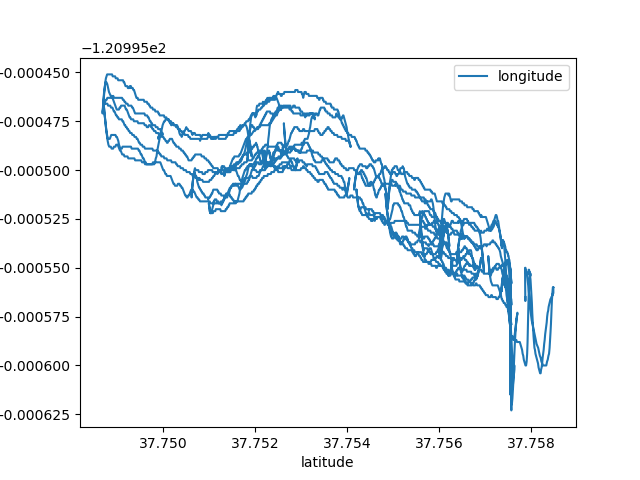

In [21]:
data[data["latitude"]>0.1][["latitude","longitude"]].plot(x="latitude",y="longitude")

In [22]:
px.scatter(
    data[(data["latitude"]!=0.000000)&
                   (data["density"]>=91.6)
                  ][["latitude","longitude","passID","density","time","heading"]],
    x="latitude",
    y="longitude",
    hover_name="passID", 
    hover_data=["time", "density"],
    color="density",
    width=800,
    height=800
)

In [5]:
#create new PassID

# Elk-grove: need to calculate passID

In [44]:
# mcHenry_location_4

px.scatter(
    data[
         (data["latitude"]>=37.75543)&
         (data["latitude"]<=37.75560)&
         (data["longitude"]>=-120.99554)&
         (data["longitude"]<=-120.9955)&
         (data["passID"]>=95)&
         (data["passID"]<110)&
         (data["density"]>=91.1)
                  ][["latitude","longitude","passID","density","time"]],
    x="latitude",
    y="longitude",
    hover_name="passID", 
    hover_data=["time", "density"],
    color="density",
    width=1000,
    height=800
)

In [45]:
data_to_look=data[
         (data["latitude"]>=37.75543)&
         (data["latitude"]<=37.75560)&
         (data["longitude"]>=-120.99554)&
         (data["longitude"]<=-120.9955)&
         (data["passID"]>=95)&
         (data["passID"]<110)&
         (data["density"]>=91.1)
                  ]
# def get_start_stop(data_to_look):
passIDs=data_to_look.passID.unique()
loc_in_time_list=[[data_to_look[data["passID"]==x].time.min(),
  data_to_look[data["passID"]==x].time.max(),
  x,
  data_to_look[data["passID"]==x].latitude.min(),
  data_to_look[data["passID"]==x].latitude.max(),
  data_to_look[data["passID"]==x].longitude.min(),
  data_to_look[data["passID"]==x].longitude.max(),
 ] 
 for x in passIDs]
loc_in_time_list

location_4_in_time_df1=pd.DataFrame(loc_in_time_list,columns=["Start","End","passID","lat_min","lat_max","long_min","long_max"])


print(location_4_in_time_df1)

# location_1_in_time_df1["Start"]=pd.to_datetime(location_1_in_time_df1["Start"], format="%Y-%m-%dT%H:%m:%s.%fZ")
# location_1_in_time_df1["End"]=pd.to_datetime(location_1_in_time_df1["End"], format="%Y-%m-%dT%H:%m:%s.%fZ")

location_4_in_time_df1.to_csv("/home/spoudel/All_Thesis/Thesis_program/Data/McHenry/location_4/location_in_time.csv")

loc_in_time_list

                      Start                       End  passID    lat_min  \
0  2022-10-18T15:48:01.075Z  2022-10-18T15:48:14.643Z      99  37.755440   
1  2022-10-18T15:49:42.707Z  2022-10-18T15:49:54.611Z     101  37.755442   
2  2022-10-18T15:51:33.811Z  2022-10-18T15:51:47.635Z     102  37.755433   
3  2022-10-18T15:59:53.779Z  2022-10-18T16:00:09.651Z     105  37.755436   
4  2022-10-18T16:01:47.699Z  2022-10-18T16:02:04.595Z     107  37.755434   

     lat_max    long_min    long_max  
0  37.755596 -120.995506 -120.995504  
1  37.755590 -120.995514 -120.995513  
2  37.755590 -120.995528 -120.995528  
3  37.755594 -120.995534 -120.995532  
4  37.755594 -120.995523 -120.995522  


/home/spoudel/anaconda3/envs/rica/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



[['2022-10-18T15:48:01.075Z',
  '2022-10-18T15:48:14.643Z',
  99,
  37.75544,
  37.755596,
  -120.995506,
  -120.995504],
 ['2022-10-18T15:49:42.707Z',
  '2022-10-18T15:49:54.611Z',
  101,
  37.755442,
  37.75559,
  -120.995514,
  -120.995513],
 ['2022-10-18T15:51:33.811Z',
  '2022-10-18T15:51:47.635Z',
  102,
  37.755433,
  37.75559,
  -120.995528,
  -120.995528],
 ['2022-10-18T15:59:53.779Z',
  '2022-10-18T16:00:09.651Z',
  105,
  37.755436,
  37.755594,
  -120.995534,
  -120.995532],
 ['2022-10-18T16:01:47.699Z',
  '2022-10-18T16:02:04.595Z',
  107,
  37.755434,
  37.755594,
  -120.995523,
  -120.995522]]

In [19]:
location_in_time_array=np.array(location_1_in_time_df1).T[1:].T

print(location_in_time_array[:,:3])

[['2022-09-29T19:40:39.969Z' 70 37.819064]
 ['2022-09-29T19:44:05.921Z' 71 37.819069]
 ['2022-09-29T19:46:58.977Z' 72 37.819088]
 ['2022-09-29T19:50:28.897Z' 73 37.819088]
 ['2022-09-29T19:53:37.953Z' 74 37.819076]]


In [22]:
Lathrop

# location_1_in_time=[["2022-09-29T19:39:34.000Z" , "2022-09-29T19:40:40.000Z",70],
#                     ["2022-09-29T19:43:01.000Z" , "2022-09-29T19:44:06.000Z",71],
#                    ["2022-09-29T19:45:51.000Z" , "2022-09-29T19:46:59.000Z",72],
#                    ["2022-09-29T19:49:26.000Z" , "2022-09-29T19:50:29.000Z",73],
#                    ["2022-09-29T19:52:33.000Z" , "2022-09-29T19:53:38.000Z",74]]

#location_2_in_time=[['2022-09-29T21:42:20.00Z',"2022-09-29T21:43:16.00Z",149],
#                     ['2022-09-29T21:44:52.897Z', '2022-09-29T21:45:49.729Z', 150],
#                     ['2022-09-29T21:48:04.897Z', '2022-09-29T21:49:02.753Z', 151],
#                     ['2022-09-29T21:50:44.897Z', '2022-09-29T21:51:42.753Z', 152],
#                     ['2022-09-29T21:53:55.873Z', '2022-09-29T21:54:53.729Z', 153]
#                    ]


# location_2_in_time_df=pd.DataFrame(location_2_in_time,columns=["Start","End","passID"])
# location_2_in_time_df.to_csv("/home/spoudel/Thesis/Thesis_program/Data/lathrop/location_2/location_in_time.csv")

# # [print(start,end,passID) for start,end,passID in location_1_in_time]
# location_2_in_time_df

In [90]:
def processed_data_to_look(data,start,end):
    to_ret_data=data[((data["time"]>=start)&
                      (data["time"]<=end))]
    if data["passID"][0]!=data["passID"].iloc[-1]:
        print(f'Error::: may have multiple pass in between {start} and {end}, passes {data["passID"].iloc[0]} and {data["passID"].iloc[-1]}')
    print(to_ret_data["passID"].iloc[0])
    return to_ret_data
    
data_to_look=pd.concat([processed_data_to_look(data,start,end) for start,end, passID in location_1_in_time])

px.scatter(
    data_to_look[["latitude","longitude","passID","density","time"]],
    x="latitude",
    y="longitude",
    hover_name="passID", 
    hover_data=["time", "density"],
    color="density",
    width=800,
    height=800
)

70
71
72
73
74


In [127]:
# def query_it(str1,client = InfluxDBClient(host="127.0.0.1", port=8086, database="lathrop")):
#     x=client.query(str1)
#     data = pd.DataFrame(x.get_points())
# #     data.time = pd.to_datetime(data.time)
#     return data

# def query_betn(s_datetime,e_datetime,table="raw",client = InfluxDBClient(host="127.0.0.1", port=8086, database="lathrop")):
#     x = client.query(
#         f"select * from {table} where time>='{s_datetime}' and time<'{e_datetime}'"
#     )
#     data=pd.DataFrame(x.get_points())
#     data.time=pd.to_datetime(data.time)
#     return data

In [128]:
# def save_raw(start,stop,passID,to_save_location):
#     raw_data=query_betn(start,stop)
#     raw_data.to_csv(Path(to_save_location)/f"raw_data_pass_{passID}.csv")

# [save_raw(start,stop,passID,"/home/spoudel/Thesis/Thesis_program/Data/lathrop/location_1/") for start,stop,passID in location_1_in_time]    

In [129]:
# np.array(location_1_in_time_df)

In [11]:
a=[1,2,3]
b=[10,20,30]
c=[.1,.2,.3]
f=[100,200,300]
np.array([(a*b+c)*d for a,b,c,d in zip(a,b,c,f)])/100

array([ 10.1,  80.4, 270.9])

In [14]:
p=np.array([0,3,2,4,1])
idx=p.argsort()
p[idx]

array([0, 1, 2, 3, 4])

In [ ]:
# # shawnee_location_1

# px.scatter(
#     data[(data["latitude"]!=0.000000)&
#          (data["latitude"]>=35.6700)&
#          (data["latitude"]<=35.6708)&
#          (data["longitude"]>=-96.66235)&
#          (data["longitude"]<=-96.66230)&
#          (data["passID"]>=114)&
#          (data["passID"]<125)&
#          (data["density_post"]>=90.1)
#                   ][["latitude","longitude","passID","density_post","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density_post"],
#     color="density_post",
#     width=1000,
#     height=800
# )


### Shawnee_location_2

# px.scatter(
#     data[(data["latitude"]!=0.000000)&
#          (data["latitude"]>=35.6710)&
#          (data["latitude"]<=35.6715)&
#          (data["longitude"]>=-96.662355)&
#          (data["longitude"]<=-96.662325)&
#          (data["passID"]>=119)&
#          (data["passID"]<135)&
#          (data["density_post"]>=90.1)
#                   ][["latitude","longitude","passID","density_post","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density_post"],
#     color="density_post",
#     width=1000,
#     height=800
# )


# # shawnee_location_3

# px.scatter(
#     data[(data["latitude"]!=0.000000)&
#          (data["latitude"]>=35.67355)&
#          (data["latitude"]<=35.6741)&
#          (data["longitude"]>=-96.662500)&
#          (data["longitude"]<=-96.662375)&
#          (data["passID"]>=163)&
#          (data["passID"]<173)&
#          (data["density_post"]>=90.1)
#                   ][["latitude","longitude","passID","density_post","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density_post"],
#     color="density_post",
#     width=1000,
#     height=800
# )

In [ ]:
#shawnee

# location_3_in_time=[['2023-01-16T8:25:21.000Z','2023-01-16T18:25:50.000Z',164,35.673633,35.6741,-96.662387,-96.662375],
#                     ['2023-01-16T8:26:18.000Z','2023-01-16T18:26:49.000Z',165,35.673566,35.674087,-96.662386,-96.662378],
#                     ['2023-01-16T8:27:16.000Z','2023-01-16T18:27:46.000Z',166,35.673563,35.674084,-96.662407,-96.662396],
#                     ['2023-01-16T8:28:17.000Z','2023-01-16T18:28:48.000Z',168,35.673563,35.674084,-96.662407,-96.662398],
#                     ['2023-01-16T8:29:21.000Z','2023-01-16T18:29:51.000Z',169,35.673566,35.674084,-96.662398,-96.662389]]

# location_2_in_time=[["2023-01-16T17:34:19.000Z" , "2023-01-16T17:34:48.000Z",125,35.671009,35.671484,-96.662335,-96.662326],
#                     ["2023-01-16T17:35:24.000Z" , "2023-01-16T17:35:53.000Z",126,35.671015,35.671497,-96.662334,-96.662326],
#                     ["2023-01-16T17:36:52.000Z" , "2023-01-16T17:37:16.000Z",127,35.671011,35.671399,-96.662355,-96.662348],
#                     ["2023-01-16T17:38:04.000Z" , "2023-01-16T17:38:28.000Z",128,35.671016,35.671406,-96.662355,-96.662347],
#                     ["2023-01-16T17:39:08.000Z" , "2023-01-16T17:39:38.000Z",129,35.671005,35.671495,-96.662349,-96.662337]]

# location_1_in_time=[["2023-01-16T17:24:39.000Z" , "2023-01-16T17:25:25.000Z",115,35.670006,35.670785,-96.662316,-96.662305],
#                     ["2023-01-16T17:25:52.000Z" , "2023-01-16T17:26:38.000Z",117,35.670014,35.670792,-96.662317,-96.662304],
#                     ["2023-01-16T17:27:08.000Z" , "2023-01-16T17:27:55.000Z",118,35.670003,35.6708,-96.662341,-96.662327],
#                     ["2023-01-16T17:29:06.000Z" , "2023-01-16T17:29:53.000Z",120,35.67,35.670794,-96.662342,-96.662329],
#                     ["2023-01-16T17:30:23.000Z" , "2023-01-16T17:31:09.000Z",121,35.670007,35.670784,-96.662333,-96.662319]]

# location_3_in_time_df=pd.DataFrame(location_3_in_time,columns=["Start","End","passID","lat_min","lat_max","long_min","long_max"])
# location_3_in_time_df.to_csv("/home/spoudel/All_Thesis/Thesis_program/Data/shawnee/location_3/location_in_time.csv")

# # [print(start,end,passID) for start,end,passID in location_1_in_time]
# location_3_in_time_df

In [ ]:
# # Lathrop location_1

# px.scatter(
#     data[
#          (data["latitude"]>=37.819064)&
#          (data["latitude"]<=37.81907)&
#          (data["longitude"]>=-121.2858)&
#          (data["longitude"]<=-121.2848)&
#          (data["time"]>"2022-09-29T19:39:34.000Z") & 
#          (data["time"]<"2022-09-29T19:40:40.000Z") &
#          (data["passID"]>=70)&
#          (data["passID"]<75)&
#          (data["density"]>=90.1)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )


# lathrop_location_2

# px.scatter(
#     data[(((data["time"]>"2022-09-29T21:42:20.00Z") & 
#          (data["time"]<"2022-09-29T21:43:16.00Z")) |
#          ((data["time"]>"2022-09-29T21:44:52.897Z") &
#          (data["time"]<"2022-09-29T21:45:49.729Z"))|
#          ((data["time"]>"2022-09-29T21:48:04.897Z") &
#          (data["time"]<"2022-09-29T21:49:02.753Z")) |
#          ((data["time"]>"2022-09-29T21:50:44.897Z") &
#          (data["time"]<"2022-09-29T21:51:42.753Z")) |
#          ((data["time"]>"2022-09-29T21:53:55.873Z") &
#          (data["time"]<"2022-09-29T21:54:53.729Z")) )&
#          (data["passID"]>=149)&
#          (data["passID"]<154)&
#          (data["density"]>=90.1)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )

#lathrop location_3
# px.scatter(
#     data[
#          (data["latitude"]>=37.81874)&
#          (data["latitude"]<=37.8188)&
#          (data["longitude"]>=-121.2800)&
#          (data["longitude"]<=-121.2795)&
#          (data["passID"]>=106)&
#          (data["passID"]<115)&
#          (data["density"]>=90.1)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )

In [ ]:
#Lathrop 
# location_1

# location_1=[['2022-09-29T19:39:34.049Z','2022-09-29T19:40:39.969Z',70, 37.819064,37.81907,-121.285808,-121.284786],
#             ['2022-09-29T19:43:01.025Z','2022-09-29T19:44:05.921Z',71,37.819069,37.819074,-121.285814,-121.28481],
#             ['2022-09-29T19:45:51.009Z','2022-09-29T19:46:58.977Z',72,37.819088,37.819093,-121.285815,-121.284795],
#             ['2022-09-29T19:49:26.049Z','2022-09-29T19:50:28.897Z',73,37.819088,37.81909,-121.285778,-121.284803],
#             ['2022-09-29T19:52:33.057Z','2022-09-29T19:53:37.953Z',74,37.819076,37.819082,-121.28581,-121.284818]]

# Location_2

location_2=[['2022-09-29T21:42:20.065Z',
  '2022-09-29T21:43:16.001Z',
  149,
  37.819123,
  37.819127,
  -121.291005,
  -121.290114],
 ['2022-09-29T21:44:53.025Z',
  '2022-09-29T21:45:49.601Z',
  150,
  37.819124,
  37.819129,
  -121.290992,
  -121.290114],
 ['2022-09-29T21:48:05.025Z',
  '2022-09-29T21:49:02.625Z',
  151,
  37.819115,
  37.819118,
  -121.290987,
  -121.290102],
 ['2022-09-29T21:50:45.025Z',
  '2022-09-29T21:51:42.625Z',
  152,
  37.819115,
  37.81912,
  -121.290994,
  -121.290103],
 ['2022-09-29T21:53:56.001Z',
  '2022-09-29T21:54:53.601Z',
  153,
  37.819117,
  37.819123,
  -121.290988,
  -121.2901]]



#Location 3

location_3= [['2022-09-29T20:39:28.929Z',
  '2022-09-29T20:40:02.721Z',
  107,
  37.818756,
  37.818759,
  -121.279997,
  -121.279507],
 ['2022-09-29T20:40:49.953Z',
  '2022-09-29T20:41:22.721Z',
  108,
  37.818754,
  37.818757,
  -121.279994,
  -121.27951],
 ['2022-09-29T20:47:41.857Z',
  '2022-09-29T20:48:15.777Z',
  111,
  37.818784,
  37.818786,
  -121.28,
  -121.279508],
 ['2022-09-29T20:49:37.825Z',
  '2022-09-29T20:50:10.721Z',
  112,
  37.818783,
  37.818785,
  -121.279985,
  -121.279501],
 ['2022-09-29T20:55:03.841Z',
  '2022-09-29T20:55:37.761Z',
  114,
  37.818767,
  37.81877,
  -121.279992,
  -121.2795]]

In [18]:
# Mchenry locations
# Location1

# mcHenry_location_1

# px.scatter(
#     data[
#          (data["latitude"]>=37.7501)&
#          (data["latitude"]<=37.7506)&
#          (data["longitude"]>=-120.995515)&
#          (data["longitude"]<=-120.995475)&
#          (data["passID"]>=138)&
#          (data["passID"]<150)&
#          (data["density"]>=91.1)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )

# mcHenry_location_2

# px.scatter(
#     data[
#          (data["latitude"]>=37.7552)&
#          (data["latitude"]<=37.75560)&
#          (data["longitude"]>=-120.99554)&
#          (data["longitude"]<=-120.9955)&
# #          (data["passID"]>=138)&
# #          (data["passID"]<150)&
#          (data["density"]>=91.1)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )


# mcHenry_location_3

# px.scatter(
#     data[
#          (data["latitude"]>=37.7501)&
#          (data["latitude"]<=37.7506)&
#          (data["longitude"]>=-120.995515)&
#          (data["longitude"]<=-120.995475)&
#          (data["passID"]>=139)&
#          (data["passID"]<147)&
#          (data["density"]>=91.6)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )


# mcHenry_location_4

# px.scatter(
#     data[
#          (data["latitude"]>=37.75543)&
#          (data["latitude"]<=37.75560)&
#          (data["longitude"]>=-120.99554)&
#          (data["longitude"]<=-120.9955)&
#          (data["passID"]>=95)&
#          (data["passID"]<110)&
#          (data["density"]>=91.1)
#                   ][["latitude","longitude","passID","density","time"]],
#     x="latitude",
#     y="longitude",
#     hover_name="passID", 
#     hover_data=["time", "density"],
#     color="density",
#     width=1000,
#     height=800
# )

In [ ]:
# Mchenry location_1
location_1=[['2022-10-18T16:55:00.019Z',
  '2022-10-18T16:55:27.539Z',
  139,
  37.750142,
  37.750591,
  -120.995483,
  -120.995475],
 ['2022-10-18T16:58:25.715Z',
  '2022-10-18T16:58:57.587Z',
  140,
  37.750101,
  37.750597,
  -120.995514,
  -120.995503],
 ['2022-10-18T17:02:34.675Z',
  '2022-10-18T17:03:05.523Z',
  143,
  37.75011,
  37.750597,
  -120.995502,
  -120.995495],
 ['2022-10-18T17:06:07.667Z',
  '2022-10-18T17:06:39.539Z',
  145,
  37.750102,
  37.750589,
  -120.995495,
  -120.995484],
 ['2022-10-18T17:09:37.203Z',
  '2022-10-18T17:10:05.363Z',
  146,
  37.750218,
  37.750596,
  -120.995484,
  -120.995476],
 ['2022-10-18T17:10:20.083Z',
  '2022-10-18T17:10:24.563Z',
  148,
  37.750128,
  37.750178,
  -120.995477,
  -120.995475]]


# McHenry location_2

[['2022-10-18T15:48:01.075Z',
  '2022-10-18T15:48:34.611Z',
  99,
  37.755201,
  37.755596,
  -120.995506,
  -120.995501],
 ['2022-10-18T15:49:25.683Z',
  '2022-10-18T15:49:54.611Z',
  101,
  37.755208,
  37.75559,
  -120.995514,
  -120.99551],
 ['2022-10-18T15:51:33.811Z',
  '2022-10-18T15:52:02.611Z',
  102,
  37.755253,
  37.75559,
  -120.995528,
  -120.995526],
 ['2022-10-18T15:53:07.763Z',
  '2022-10-18T15:53:16.595Z',
  103,
  37.755204,
  37.755307,
  -120.99554,
  -120.995538],
 ['2022-10-18T15:55:58.771Z',
  '2022-10-18T15:56:20.531Z',
  104,
  37.7552,
  37.755422,
  -120.99554,
  -120.995534],
 ['2022-10-18T15:59:31.763Z',
  '2022-10-18T16:00:09.651Z',
  105,
  37.755204,
  37.755594,
  -120.995534,
  -120.995522],
 ['2022-10-18T16:01:47.699Z',
  '2022-10-18T16:02:26.867Z',
  107,
  37.755205,
  37.755594,
  -120.995523,
  -120.995515],
 ['2022-10-18T16:05:46.675Z',
  '2022-10-18T16:05:47.955Z',
  109,
  37.75525,
  37.755262,
  -120.995503,
  -120.995501],
 ['2022-10-18T16:07:21.779Z',
  '2022-10-18T16:07:55.571Z',
  110,
  37.755209,
  37.755597,
  -120.995538,
  -120.995534]]


#McHenry Location 3

[['2022-10-18T16:55:00.147Z',
  '2022-10-18T16:55:27.539Z',
  139,
  37.750142,
  37.750591,
  -120.995483,
  -120.995475],
 ['2022-10-18T16:58:25.715Z',
  '2022-10-18T16:58:57.587Z',
  140,
  37.750101,
  37.750597,
  -120.995514,
  -120.995503],
 ['2022-10-18T17:02:34.675Z',
  '2022-10-18T17:03:05.523Z',
  143,
  37.75011,
  37.750597,
  -120.995502,
  -120.995495],
 ['2022-10-18T17:06:07.667Z',
  '2022-10-18T17:06:39.283Z',
  145,
  37.750102,
  37.750589,
  -120.995495,
  -120.995484],
 ['2022-10-18T17:09:37.203Z',
  '2022-10-18T17:10:05.363Z',
  146,
  37.750218,
  37.750596,
  -120.995484,
  -120.995476]]